### Выбранные стили: y2k vs classic

### 1. Сбор небольшого датасета

По 20 изображений каждого стиля сохранениы в папке `data`:
- `/style_1` - y2k
- `/style_2` - classic

### 2. Мини-анализ стилей

   **y2k**: яркий, броский, насыщенный стиль, характерный для моды конца 90-х – начала 2000-х. Он отличается обилием блестящих материалов, металлизированных поверхностей, трикотажа с эластичностью, количеством открытых элементов, низкой посадкой брюк, обилием аксессуаров и насыщенной цветовой палитрой. Силуэты часто акцентирующие фигуру как засчет только приталенности, так и засчет сочетания ее с объемными вещам. Текстуры включают глянец, деним, кожу, меховые детали и принты. Обувь часто на высоком тонком каблуке или же акцентная спортивная. Характерен для тинейджеров.
   
   **classic**: характерны минимализм и структурированность, актуальность сквозь года. Этот стиль использует качественные натуральные материалы: шерсть, хлопок, кашемир, кожу. А также нейтральные и приглушённые цвета: чёрный, белый, бежевый, тёмно-синий. Силуэты чаще прямые, строгие и симметричные: пиджаки, брюки со стрелками, гладкие платья, пальто. Текстуры матовые, без лишнего декора, с чистыми линиями и чёткой посадкой. Количество аксессуаров минимально. Обувь зачастую из кожи на сдержанном каблуке. Может быть присущ людям всех возрастов.

   потенциальные признаки:
   - **цветовая гамма**: яркие/металлизированные оттенки vs нейтральные/базовые
   - **текстуры**: блеск и синтетика vs матовые натуральные материалы
   - **силуэты**: обтягивающие мини-силуэты vs строгие прямые линии
   - **детали**: y2k — декоративные элементы, обилие аксессуаров; classic — отсутствие декора, минимализм
   - **контраст на изображении**: y2k чаще имеет броские акценты и насыщенные участки
   - **обувь**: преобладают яркие, глянцевые и массивные модели vs нейтральная, минималистичная и строгая обувь
   - **возраст**: стиль y2k чаще встречается у подростков и молодых людей, classic встречается у всех

### 3. Обучение небольшой модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchvision import models, datasets
import torch
import torch.nn as nn
from PIL import Image, ImageFilter

from glob import glob

import cv2

import seaborn as sns

from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, ConcatDataset, Subset

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [3]:
original_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [4]:
pipeline1 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.ToTensor(),
    normalize
])

pipeline2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=1.0),
    transforms.ToTensor(),
    normalize
])

pipeline3 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),
    transforms.ToTensor(),
    normalize
])

pipeline4 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.02),
    transforms.ToTensor(),
    normalize
])

In [5]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [6]:
train_original = datasets.ImageFolder("data/train", transform=original_transforms)
train_aug1 = datasets.ImageFolder("data/train", transform=pipeline1)
train_aug2 = datasets.ImageFolder("data/train", transform=pipeline2)
train_aug3 = datasets.ImageFolder("data/train", transform=pipeline3)
train_aug4 = datasets.ImageFolder("data/train", transform=pipeline4)

train_dataset = ConcatDataset([train_original, train_aug1, train_aug2, train_aug3, train_aug4])
val_dataset   = datasets.ImageFolder("data/val",   transform=val_transforms)

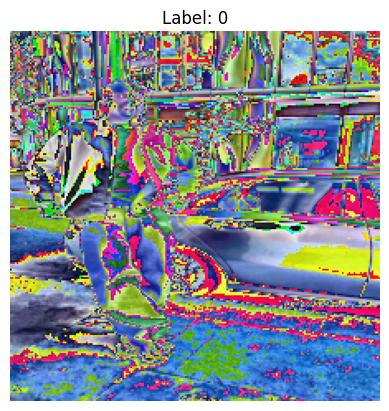

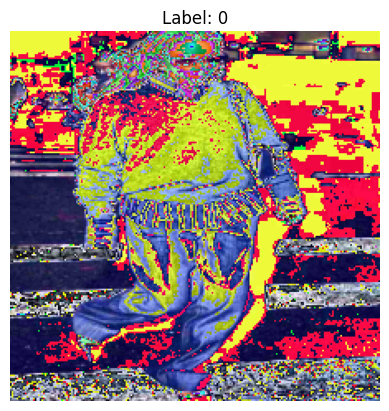

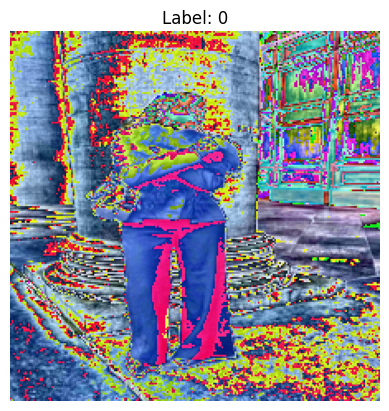

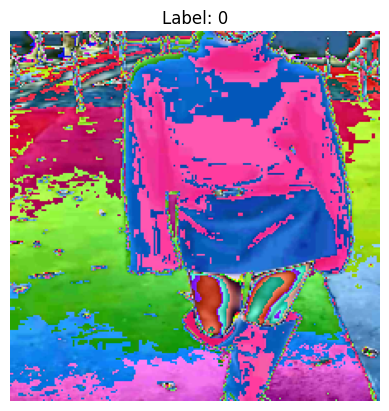

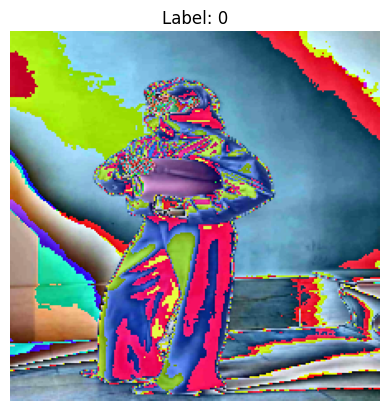

In [7]:
from torchvision.transforms.functional import to_pil_image

for i in range(5):     
    img, label = train_original[i]   # достаём первое изображение
    
    plt.imshow(to_pil_image(img))  # переводим тензор → изображение
    plt.axis("off")
    plt.title(f"Label: {label}")
    plt.show()


In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [9]:
model = models.resnet18(pretrained=True)

/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Modify the last layer of the model
num_classes = 2 
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [12]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Determine whether to use GPU (if available) or CPU
    device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

    train_losses = []
    val_losses = []

    train_accuracy = []
    val_accuracy = []

    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()

        # Initialize running loss and correct predictions count for training
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the training data loader
        for inputs, labels in train_loader:
            # Move inputs and labels to the device (GPU or CPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Reset the gradients to zero before the backward pass
            optimizer.zero_grad()

            # Forward pass: compute the model output
            outputs = model(inputs)
            # Get the predicted class (with the highest score)
            _, preds = torch.max(outputs, 1)
            # Compute the loss between the predictions and actual labels
            loss = criterion(outputs, labels)

            # Backward pass: compute gradients
            loss.backward()
            # Perform the optimization step to update model parameters
            optimizer.step()

            # Accumulate the running loss and the number of correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Compute average training loss and accuracy for this epoch
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.float() / len(train_loader.dataset)

        # Set the model to evaluation mode for validation
        model.eval()
        # Initialize running loss and correct predictions count for validation
        running_loss = 0.0
        running_corrects = 0

        # Disable gradient computation for validation (saves memory and computations)
        with torch.no_grad():
            # Iterate over the validation data loader
            for inputs, labels in val_loader:
                # Move inputs and labels to the device (GPU or CPU)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass: compute the model output
                outputs = model(inputs)
                # Get the predicted class (with the highest score)
                _, preds = torch.max(outputs, 1)
                # Compute the loss between the predictions and actual labels
                loss = criterion(outputs, labels)

                # Accumulate the running loss and the number of correct predictions
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        # Compute average validation loss and accuracy for this epoch
        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.float() / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        train_accuracy.append(train_acc.item())
        val_accuracy.append(val_acc.item())

        # Print the results for the current epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

    return train_losses, val_losses, train_accuracy, val_accuracy

In [13]:
def train_kfold(model_class, dataset, k_splits, criterion, optimizer_fn,
                batch_size, num_epochs):

    # Stratified — важно для балансировки классов
    targets = [dataset[i][1] for i in range(len(dataset))]
    skf = StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=42)

    all_fold_results = []

    fold_idx = 1
    for train_idx, val_idx in skf.split(range(len(dataset)), targets):
        print(f"\n Fold {fold_idx}/{k_splits} ")

        # Подмножества датасета
        train_subset = Subset(dataset, train_idx)
        val_subset   = Subset(dataset, val_idx)

        # Даталоадеры
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_subset,   batch_size=batch_size, shuffle=False)

        # Новая модель и новый оптимизатор (критично!)
        model = model_class()
        optimizer = optimizer_fn(model)

        # Запуск твоей функции тренировки
        train_loss, val_loss, train_acc, val_acc = train(
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            num_epochs
        )

        all_fold_results.append({
            "fold": fold_idx,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc
        })

        fold_idx += 1

    return all_fold_results


In [14]:
full_dataset = ConcatDataset([train_original, train_aug1, train_aug2, train_aug3, train_aug4])

In [15]:
def make_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        return self.model(x)

In [17]:
results = train_kfold(
    model_class=MyModel,
    dataset=full_dataset,
    k_splits=5,
    criterion=criterion,
    optimizer_fn=make_optimizer,
    batch_size=16,
    num_epochs=25
)


 Fold 1/5 


/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/25], train loss: 0.4435, train acc: 0.7750, val loss: 0.1778, val acc: 1.0000
Epoch [2/25], train loss: 0.0769, train acc: 0.9750, val loss: 0.0283, val acc: 1.0000
Epoch [3/25], train loss: 0.0220, train acc: 1.0000, val loss: 0.0051, val acc: 1.0000
Epoch [4/25], train loss: 0.0114, train acc: 1.0000, val loss: 0.0044, val acc: 1.0000
Epoch [5/25], train loss: 0.0040, train acc: 1.0000, val loss: 0.0026, val acc: 1.0000
Epoch [6/25], train loss: 0.0038, train acc: 1.0000, val loss: 0.0024, val acc: 1.0000
Epoch [7/25], train loss: 0.0036, train acc: 1.0000, val loss: 0.0015, val acc: 1.0000
Epoch [8/25], train loss: 0.0335, train acc: 0.9833, val loss: 0.0044, val acc: 1.0000
Epoch [9/25], train loss: 0.0080, train acc: 1.0000, val loss: 0.0033, val acc: 1.0000
Epoch [10/25], train loss: 0.0033, train acc: 1.0000, val loss: 0.0064, val acc: 1.0000
Epoch [11/25], train loss: 0.0015, train acc: 1.0000, val loss: 0.0069, val acc: 1.0000
Epoch [12/25], train loss: 0.0030, train 

In [37]:
def plot_training_results(
    train_losses,
    val_losses,
    train_acc,
    val_acc,
    title=None
):
    if isinstance(train_losses[0], (list, np.ndarray)):
        train_losses = np.mean(train_losses, axis=0)
        val_losses   = np.mean(val_losses, axis=0)
        train_acc    = np.mean(train_acc, axis=0)
        val_acc      = np.mean(val_acc, axis=0)

    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(epochs, train_losses, label="Train", linewidth=2)
    axes[0].plot(epochs, val_losses, label="Validation", linewidth=2)
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(epochs, train_acc, label="Train", linewidth=2)
    axes[1].plot(epochs, val_acc, label="Validation", linewidth=2)
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    if title:
        fig.suptitle(title, fontsize=14)

    plt.tight_layout()
    plt.show()


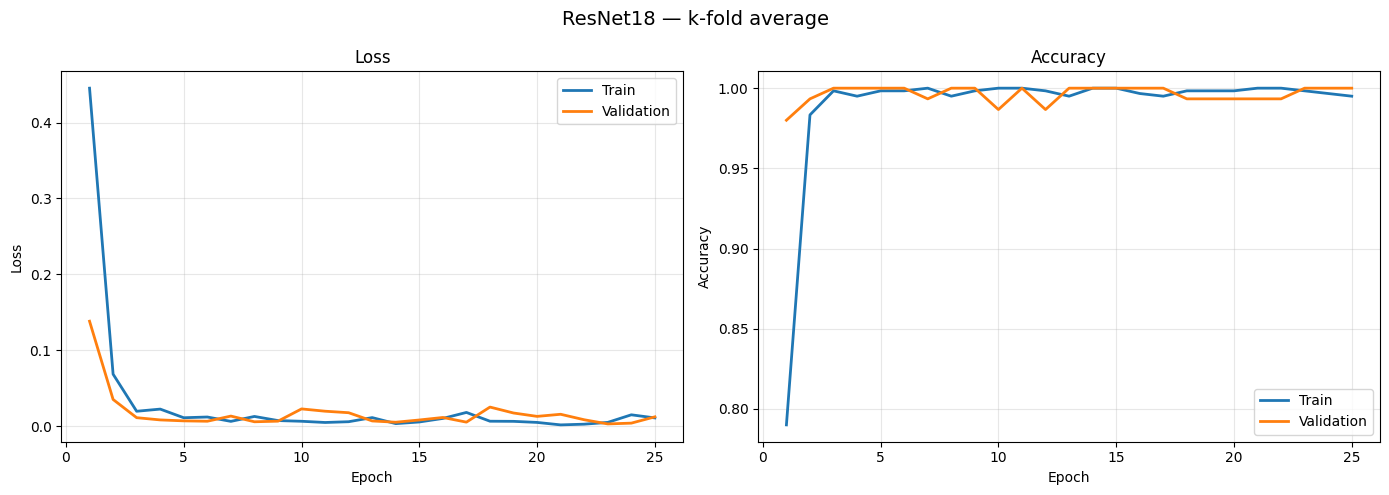

In [27]:
train_losses = [r["train_loss"] for r in results]
val_losses   = [r["val_loss"]   for r in results]
train_acc    = [r["train_acc"]  for r in results]
val_acc      = [r["val_acc"]    for r in results]

plot_training_results(
    train_losses,
    val_losses,
    train_acc,
    val_acc,
    title="ResNet18 — k-fold average"
)

In [33]:
clipped_results = []
for res in results:
    clipped_results.append({
            "fold": res['fold'],
            "train_loss": res['train_loss'][:5],
            "val_loss": res['val_loss'][:5],
            "train_acc": res['train_acc'][:5],
            "val_acc": res['val_acc'][:5]
        })

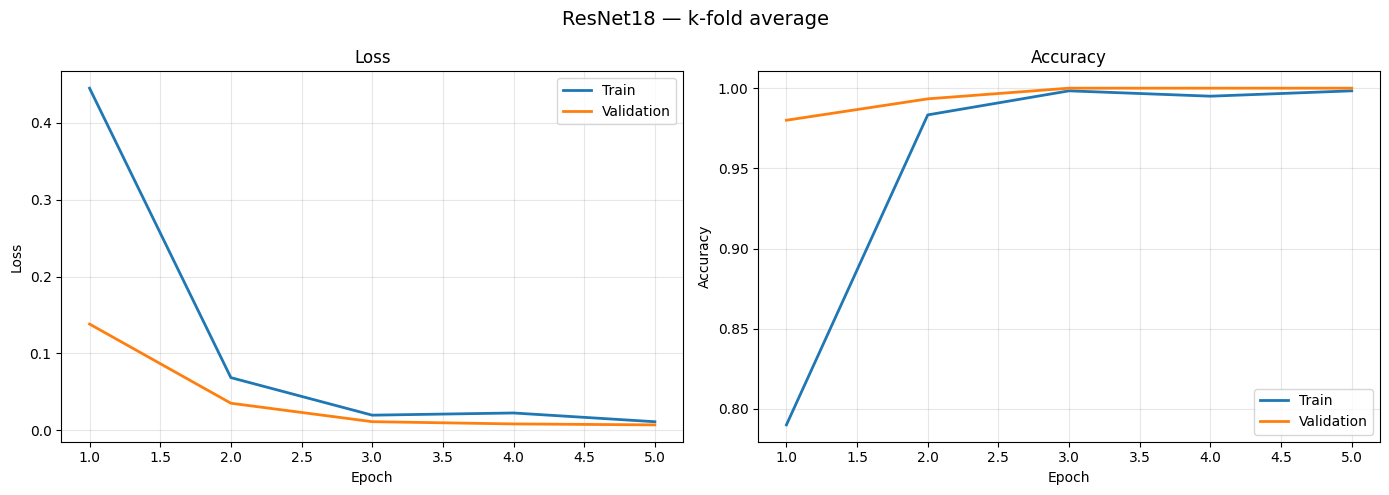

In [38]:
train_losses = [r["train_loss"] for r in clipped_results]
val_losses   = [r["val_loss"]   for r in clipped_results]
train_acc    = [r["train_acc"]  for r in clipped_results]
val_acc      = [r["val_acc"]    for r in clipped_results]

plot_training_results(
    train_losses,
    val_losses,
    train_acc,
    val_acc,
    title="ResNet18 — k-fold average"
)

In [18]:
# train_losses, val_losses, train_accuracy, val_accuracy = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)

In [19]:
epochs = range(1, len(train_losses) + 1)

df = pd.DataFrame({
    "epoch": epochs,
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_acc": train_accuracy,
    "val_acc": val_accuracy
})

sns.set(style="whitegrid", font_scale=1.1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

def plot_metric(ax, df, y1, y2, title, ylabel):
    sns.lineplot(ax=ax, data=df, x="epoch", y=y1, marker="o", label="Train")
    sns.lineplot(ax=ax, data=df, x="epoch", y=y2, marker="o", label="Val")
    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle="--", alpha=0.4)

plot_metric(axes[0], df, "train_loss", "val_loss", "Loss: Train vs Val", "Loss")

plot_metric(axes[1], df, "train_acc", "val_acc", "Accuracy: Train vs Val", "Accuracy")

plt.tight_layout()
plt.show()

NameError: name 'train_losses' is not defined

In [ ]:
epochs = list(range(1, len(train_accuracy) + 1))
df = pd.DataFrame({
    "epoch": epochs,
    "train_acc": train_accuracy,
    "val_acc": val_accuracy
})

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df,
    x="epoch",
    y="train_acc",
    marker="o",
    linewidth=2.5,
    label="Train Accuracy"
)

sns.lineplot(
    data=df,
    x="epoch",
    y="val_acc",
    marker="o",
    linewidth=2.5,
    label="Validation Accuracy"
)

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Training vs Validation Accuracy", fontsize=16)

plt.legend(title="Legend", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

### Результаты при 20 оригинальных изображениях + 20 аугментированных от каждого класса, batch_size = 16, кол-во эпох = 15
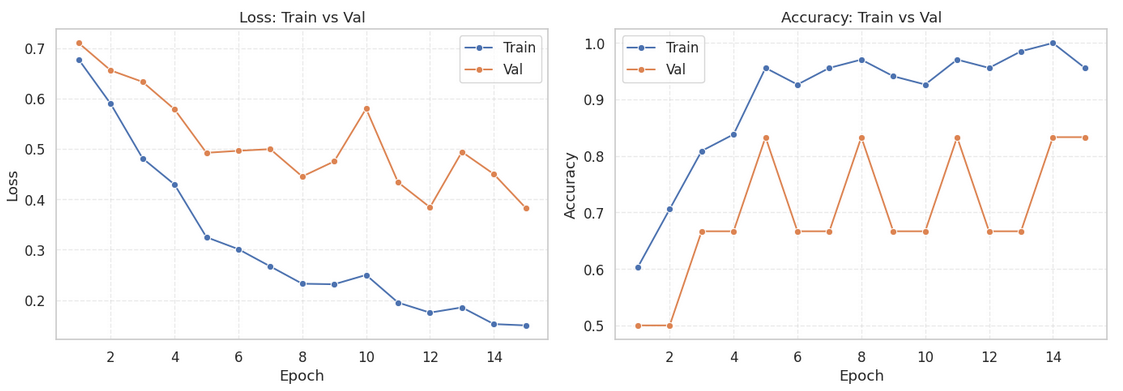

### Результаты при 20 оригинальных изображениях + 80 аугментированных от каждого класса, batch_size = 16, кол-во эпох = 15
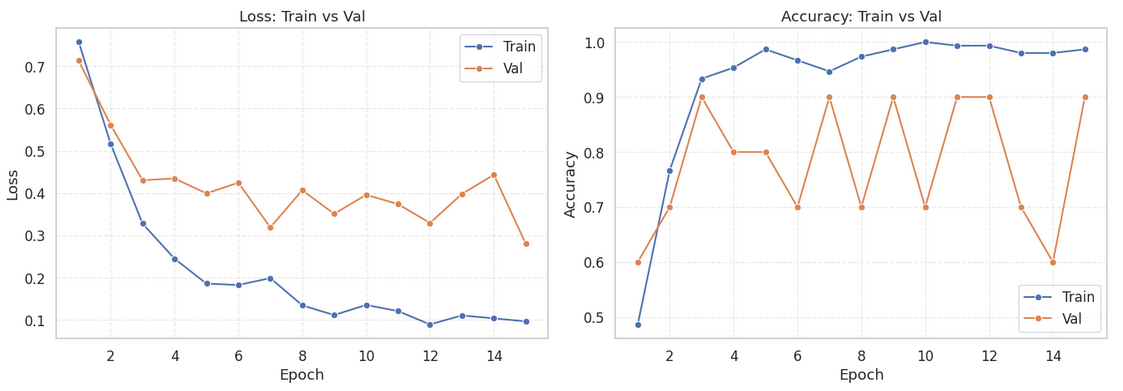
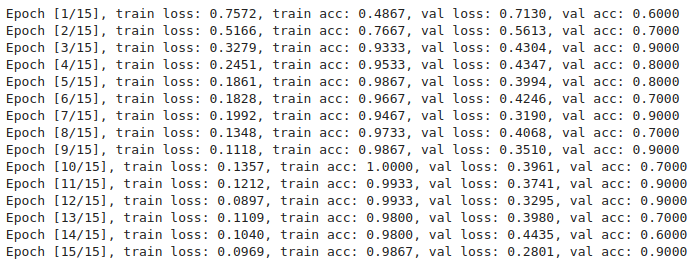

**Как собирала данные?**
На Pinterest по одноименным запросам. Следила за тем, чтобы изображения были в том числе в пределах одного из стилей разнообразными: не только по одному человеку на фото, разные ракурсы (как в полный рост, така и более детальные фото без лица), разные фоны (однотонные и нагруженные деталями), качество фотографий (как и хорошо отфотканные, так и зашумленные и пересвеченные). 

**Как подготовили изображения?**
Изображения были разделены на обучающую и валидационную выборки в соотношении 15:5, при этом все изображения приведены к единому размеру 224×224 пикселя для совместимости с предобученными CNN-моделями. Для обучающей выборки применялись различные аугментации, включая горизонтальный flip, повороты, цветовые изменения, аффинные преобразования, перспективные искажения, размытие и усиление резкости, что позволило увеличить объём данных и разнообразие обучающих примеров. После аугментаций все изображения преобразовывались в тензоры и нормализовались с использованием средних и стандартных отклонений каналов ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]). Изображения валидационной выборки не подвергались аугментациям и сохраняли исходный вид, за исключением изменения размера и нормализации.

**Какую модель выбрали и почему?**
Для классификации изображений был выбран **ResNet18**. Эта модель была выбрана из-за своей сбалансированной архитектуры: она достаточно компактная для работы с небольшими объемами данных, при этом обладает достаточной глубиной для извлечения признаков сложных изображений одежды.
